# Locality Reduction

In [1]:
import itertools

from sympy import *

from object_einsum import object_einsum
import re

sigmas = symbols('sigma1:5')

show_log = False

In [2]:

def reduce_positive_term_locality(sigmas, ancilla_symbol):
    if show_log:
        print("Reducing a term: ", prod(sigmas))
    sigma_np1 = ancilla_symbol
    res = 7 + prod(sigmas[2:]) - 3 * sigmas[0] - 3 * sigmas[1] + 6*sigma_np1 + 2 * prod(sigmas[2:]) * sigma_np1 - sigmas[0] * prod(sigmas[2:]) - sigmas[1] *prod(sigmas[2:]) - 4 * sigmas[0] * sigma_np1 - 4 * sigmas[1] * sigma_np1 + prod(sigmas[0:2])
    return res

def reduce_negative_term_locality(sigmas, ancilla_symbol):
    if show_log:
        print("Reducing a term: ", prod(sigmas))
    sigma_np1 = ancilla_symbol
    res = 5 - prod(sigmas[2:]) - sigmas[0] - sigmas[1] + 2 * sigma_np1 - 2 * prod(sigmas[2:]) * sigma_np1 + sigmas[0] * prod(sigmas[2:]) + sigmas[1] * prod(sigmas[2:]) - 4 * sigmas[0] * sigma_np1 - 4 * sigmas[1] * sigma_np1 + 3 * sigmas[0] * sigmas[1]
    return res

def separate_to_coeff_and_symbols(expr):
    syms = []
    coeffs = []
    for elem in Mul.make_args(expr):
       if type(elem) == Symbol:
           syms.append(elem)
       else:
           coeffs.append(elem)
    if coeffs:
       coeff = coeffs[0]
    else:
       coeff = 1
    return coeff, syms


def reduce_one_locality(expr, variable_name, maximum_index, to_locality):
    next_variable_index = maximum_index + 1
    reduced_expr = 0
    current_locality = 0
    for term in Add.make_args(expand(expr)):
        coeff, syms = separate_to_coeff_and_symbols(term)
        current_locality = max(current_locality, len(syms))
        if current_locality <= to_locality:
            if show_log:
                print("Skipping reduction on term: ", term)
            reduced_expr += term
            continue
        next_ancilla = Symbol(f'{variable_name}{next_variable_index}')
        if coeff > 0 :
            this_reduced_expr = reduce_positive_term_locality(syms, next_ancilla)
        else:
            coeff *= -1
            this_reduced_expr = reduce_negative_term_locality(syms, next_ancilla)
        reduced_expr += coeff * this_reduced_expr
        if show_log:
            print(f"Reduced a term into {this_reduced_expr}. Added index is ", next_variable_index)
        next_variable_index += 1
    next_maximum_index = next_variable_index - 1
    reduced_locality = current_locality - 1
    return reduced_expr, next_maximum_index, reduced_locality


def reduce_locality(expr, variable_name, maximum_index, to_locality=2):
    reduced_expr, next_maximum_index, locality = reduce_one_locality(expr, variable_name, maximum_index, to_locality)
    if show_log:
        print(f"Reduced locality to {locality}")
    if locality < to_locality:
        return expr
    elif locality == to_locality:
        return reduced_expr
    else:
        return reduce_locality(reduced_expr, variable_name, next_maximum_index)
expr = prod(symbols("sigma0:4"))
reduced_expr, total_variables_count, locality = reduce_one_locality(expr, variable_name='sigma', maximum_index=3, to_locality=3)
print("Variables count ", total_variables_count, ", Locality ", locality)
reduced_expr

Variables count  4 , Locality  3


sigma0*sigma1 - sigma0*sigma2*sigma3 - 4*sigma0*sigma4 - 3*sigma0 - sigma1*sigma2*sigma3 - 4*sigma1*sigma4 - 3*sigma1 + 2*sigma2*sigma3*sigma4 + sigma2*sigma3 + 6*sigma4 + 7

In [3]:
reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)

sigma0*sigma1 + 3*sigma0*sigma2 + sigma0*sigma3 - 4*sigma0*sigma4 - 4*sigma0*sigma5 - 4*sigma0 + 3*sigma1*sigma2 + sigma1*sigma3 - 4*sigma1*sigma4 - 4*sigma1*sigma6 - 4*sigma1 + 5*sigma2*sigma3 - 2*sigma2*sigma4 - 4*sigma2*sigma5 - 4*sigma2*sigma6 - 8*sigma2*sigma7 - 8*sigma2 - 2*sigma3*sigma4 - 2*sigma3*sigma5 - 2*sigma3*sigma6 - 8*sigma3*sigma7 - 8*sigma3 + 4*sigma4*sigma7 + 8*sigma4 + 2*sigma5 + 2*sigma6 + 12*sigma7 + 31

In [4]:
import numpy as np
def construct_hamiltonian_expr(E0, h, J, K, L):
    expr = 0
    num_variables = len(h)
    sigmas = np.array(symbols(f'sigma0:{num_variables}'), dtype=np.object)
    expr += np.dot(h, sigmas)
    expr += np.dot(sigmas, np.dot(J, sigmas))
    expr += object_einsum("ijk,i,j,k", K, sigmas, sigmas, sigmas)
    expr += object_einsum("ijkl,i,j,k,l", L, sigmas, sigmas, sigmas, sigmas)
    expr += E0
    return expr

def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]

    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [5]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")
expr = construct_hamiltonian_expr(E0, h, J, K, L)


In [6]:
reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
reduced_expr

1.14210965058458*sigma0*sigma1 - 0.67968392106266*sigma0*sigma10 + 0.925242519593277*sigma0*sigma2 + 0.00800736579361166*sigma0*sigma3 - 0.714671116297483*sigma0*sigma4 - 1.05802785499273*sigma0*sigma6 - 0.0335083292046345*sigma0*sigma7 - 0.67968392106266*sigma0*sigma8 - 1.48857130433511*sigma0 - 0.67968392106266*sigma1*sigma11 + 0.944190884810842*sigma1*sigma2 - 0.00569167520140076*sigma1*sigma3 - 0.714671116297483*sigma1*sigma4 - 0.67968392106266*sigma1*sigma5 - 1.05802785499273*sigma1*sigma6 - 0.67968392106266*sigma1*sigma8 - 1.80733072276374*sigma1 - 0.67968392106266*sigma10*sigma2 - 0.33984196053133*sigma10*sigma3 + 0.33984196053133*sigma10 - 0.67968392106266*sigma11*sigma2 - 0.33984196053133*sigma11*sigma3 + 0.33984196053133*sigma11 + 0.415176957314479*sigma2*sigma3 - 0.67968392106266*sigma2*sigma5 - 0.529013927496364*sigma2*sigma6 - 0.0335083292046345*sigma2*sigma7 - 0.33984196053133*sigma2*sigma8 - 1.35936784212532*sigma2*sigma9 - 2.01617346082703*sigma2 + 0.357335558148741*sig

In [7]:
expand(reduced_expr)

1.14210965058458*sigma0*sigma1 - 0.67968392106266*sigma0*sigma10 + 0.925242519593277*sigma0*sigma2 + 0.00800736579361166*sigma0*sigma3 - 0.714671116297483*sigma0*sigma4 - 1.05802785499273*sigma0*sigma6 - 0.0335083292046345*sigma0*sigma7 - 0.67968392106266*sigma0*sigma8 - 1.48857130433511*sigma0 - 0.67968392106266*sigma1*sigma11 + 0.944190884810842*sigma1*sigma2 - 0.00569167520140076*sigma1*sigma3 - 0.714671116297483*sigma1*sigma4 - 0.67968392106266*sigma1*sigma5 - 1.05802785499273*sigma1*sigma6 - 0.67968392106266*sigma1*sigma8 - 1.80733072276374*sigma1 - 0.67968392106266*sigma10*sigma2 - 0.33984196053133*sigma10*sigma3 + 0.33984196053133*sigma10 - 0.67968392106266*sigma11*sigma2 - 0.33984196053133*sigma11*sigma3 + 0.33984196053133*sigma11 + 0.415176957314479*sigma2*sigma3 - 0.67968392106266*sigma2*sigma5 - 0.529013927496364*sigma2*sigma6 - 0.0335083292046345*sigma2*sigma7 - 0.33984196053133*sigma2*sigma8 - 1.35936784212532*sigma2*sigma9 - 2.01617346082703*sigma2 + 0.357335558148741*sig

In [8]:
import re

def reconstruct_interaction_tensors_2_local(hamiltonian_expr):
    coeffs = []
    indices = []
    max_index = 0
    for term in Add.make_args(expand(hamiltonian_expr)):
        coeff, syms = separate_to_coeff_and_symbols(term)
        this_indices = []
        for sym in syms:
            name = sym.name
            m = re.match(r"sigma(\d+)", name)
            index = int(m.groups(0)[0])
            this_indices.append(index)
        if this_indices:
            max_index = max(max_index, max(this_indices))
        this_indices = np.array(np.sort(this_indices), dtype=np.int)
        coeffs.append(coeff)
        indices.append(this_indices)
    dim = max_index + 1
    h = np.zeros(dim)
    J = np.zeros((dim, dim))
    E0 = 0
    for i, index in enumerate(indices):
        if len(index) == 1:
            h[index[0]] = coeffs[i]
        elif len(index) == 2:
            J[index[0], index[1]] = coeffs[i]
        else:
            E0 = coeffs[i]
    return E0, h, J

In [9]:
E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)

## Testing object einsum

In [10]:
dim = 4
E0 = Symbol('E0')
h = np.array(symbols(f'h0:{dim}'))

J = np.zeros((dim, dim),dtype=np.object)
for idx in itertools.product(*[range(s) for s in J.shape]):
    s = Symbol(f'J[{idx}]')
    J[idx] = s

K = np.zeros((dim, dim, dim), dtype=np.object)
for idx in itertools.product(*[range(s) for s in K.shape]):
    s = Symbol(f'K[{idx}]')
    K[idx] = s

L = np.zeros((dim, dim, dim, dim), dtype=np.object)
for idx in itertools.product(*[range(s) for s in L.shape]):
    s = Symbol(f'L[{idx}]')
    L[idx] = s

h

array([h0, h1, h2, h3], dtype=object)

In [11]:
J

array([[J[(0, 0)], J[(0, 1)], J[(0, 2)], J[(0, 3)]],
       [J[(1, 0)], J[(1, 1)], J[(1, 2)], J[(1, 3)]],
       [J[(2, 0)], J[(2, 1)], J[(2, 2)], J[(2, 3)]],
       [J[(3, 0)], J[(3, 1)], J[(3, 2)], J[(3, 3)]]], dtype=object)

In [12]:
construct_hamiltonian_expr(E0, h, J, K, L)

E0 + K[(0, 0, 0)]*sigma0**3 + K[(0, 0, 1)]*sigma0**2*sigma1 + K[(0, 0, 2)]*sigma0**2*sigma2 + K[(0, 0, 3)]*sigma0**2*sigma3 + K[(0, 1, 0)]*sigma0**2*sigma1 + K[(0, 1, 1)]*sigma0*sigma1**2 + K[(0, 1, 2)]*sigma0*sigma1*sigma2 + K[(0, 1, 3)]*sigma0*sigma1*sigma3 + K[(0, 2, 0)]*sigma0**2*sigma2 + K[(0, 2, 1)]*sigma0*sigma1*sigma2 + K[(0, 2, 2)]*sigma0*sigma2**2 + K[(0, 2, 3)]*sigma0*sigma2*sigma3 + K[(0, 3, 0)]*sigma0**2*sigma3 + K[(0, 3, 1)]*sigma0*sigma1*sigma3 + K[(0, 3, 2)]*sigma0*sigma2*sigma3 + K[(0, 3, 3)]*sigma0*sigma3**2 + K[(1, 0, 0)]*sigma0**2*sigma1 + K[(1, 0, 1)]*sigma0*sigma1**2 + K[(1, 0, 2)]*sigma0*sigma1*sigma2 + K[(1, 0, 3)]*sigma0*sigma1*sigma3 + K[(1, 1, 0)]*sigma0*sigma1**2 + K[(1, 1, 1)]*sigma1**3 + K[(1, 1, 2)]*sigma1**2*sigma2 + K[(1, 1, 3)]*sigma1**2*sigma3 + K[(1, 2, 0)]*sigma0*sigma1*sigma2 + K[(1, 2, 1)]*sigma1**2*sigma2 + K[(1, 2, 2)]*sigma1*sigma2**2 + K[(1, 2, 3)]*sigma1*sigma2*sigma3 + K[(1, 3, 0)]*sigma0*sigma1*sigma3 + K[(1, 3, 1)]*sigma1**2*sigma3 + K[(1,

## 2-local H2

In [13]:

import re
from glob import glob
import pandas as pd
import numpy as np

from abstract_ising import AbstractIsing
import matplotlib.pyplot as plt

%matplotlib inline

In [26]:
# Write a class to describe the generalized Ising Model given its Hamiltonian parameters
def spinfield_1d(index, spin_count):
    spins = [1 if digit=='1' else -1 for digit in bin(index)[2:]]
    res = -np.ones(spin_count)
    res[spin_count -len(spins):spin_count] = spins
    return res

class IsingModel2D(AbstractIsing):

    def __init__(self, E0, h, J, seed=0):
        super().__init__()
        self.E0 = E0
        self.h = h
        self.J = J
        np.random.seed(seed)
        self.num_spins = h.shape[0]
        self.spins = 2*(np.random.rand(self.num_spins) < 0.5) - 1

    def energy(self, spins=None):
        spins = self.spins if spins is None else spins

        interaction1d = spins.dot(self.h)
        interaction2d = spins.dot(self.J.dot(spins))

        return self.E0 + interaction1d + interaction2d

    def exact(self):
        n = len(self.spins)
        all_one = 2 ** n - 1
        E = np.inf
        for i in range(all_one + 1):
            spins = spinfield_1d(i, n)
            E = min(E, self.energy(spins))
        return np.float(E)

    def energy_diff(self, i):
        diff1d = self.h[i]
        diff2d = self.J[i, :].dot(self.spins) + self.J[:, i].dot(self.spins)

        return -2 * self.spins[i] * (diff1d + diff2d)

    def rand_site(self):
        return (np.random.randint(self.num_spins),)

In [27]:
N = 1000
t = np.arange(N+1)
T_i = 400
T_f = 0.1
Ts = T_i * ((T_f/T_i) ** (t/N))

def exp_schedule(T_i, T_f, N):
    t = np.arange(N+1)
    Ts = T_i * ((T_f/T_i) ** (t/N))
    return Ts

def anneal(ising,Ts):
    Es = np.zeros_like(Ts)
    for i, t in enumerate(Ts):
        Es[i] = ising.mc_step(T=t)
    return Es

def calc_once(ising, Ts, include_exact=True, plot_title=None):

    ising.method = 'metropolis'
    Es = anneal(ising, Ts)
    Ea = min(Es)

    plt.plot(np.arange(len(Es)), Es)
    Et = None
    plt.plot(np.arange(len(Ts)), np.repeat(Ea, len(Ts)), color='g')
    if include_exact:
        Et = ising.exact()
        print("Exact: ", Et)
        plt.plot(np.arange(len(Ts)), np.repeat(Et, len(Ts)), color='r')
    if(plot_title):
        plt.title(plot_title)
    plt.show()
    return Ea, Et

Now, apply (one of) the annealing procedure(s) you came up with in the previous task to this problem to find a ground state of the system:

Exact:  -1.1299047752322915


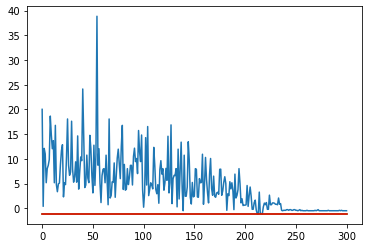

(-1.129904775232292, -1.1299047752322915)

In [28]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")
expr = construct_hamiltonian_expr(E0, h, J, K, L)
reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
ising = IsingModel2D(E0, h, J)
calc_once(ising, exp_schedule(400, 0.1, 300))
# your annealing code here

Exact:  -1.1299047752322915
Exact:  -1.1341476722233885
Exact:  -1.1113394317141143
Exact:  -1.0791929635915078
Exact:  -1.0457831649744032
Exact:  -1.0154682691531134
Exact:  -0.9904763585526108
Exact:  -0.9714267029717623
Exact:  -0.9578329791835558
Exact:  -0.9486411206967023
Exact:  -0.94267779203203
Exact:  -0.938922390740256
Exact:  -0.9366052600789354
Exact:  -0.9351960337828169
Exact:  -0.9343489902069892
Exact:  -0.9338457529323185
Exact:  -0.9335506069059241
Exact:  -0.9333799791852515
Exact:  -0.933282844565948
Exact:  -0.9332284072659007


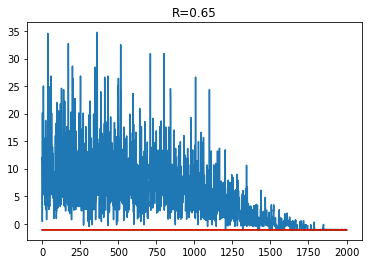

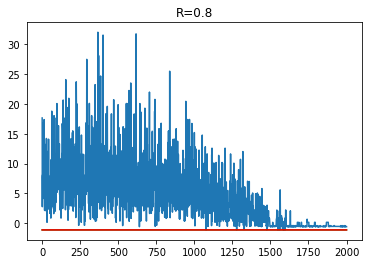

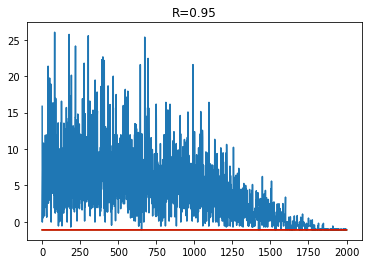

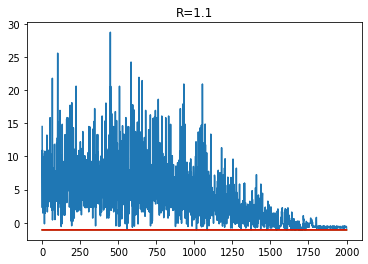

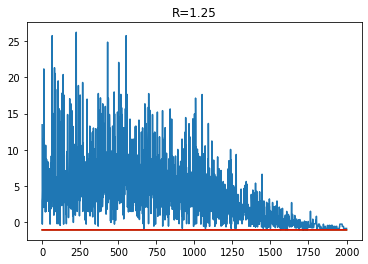

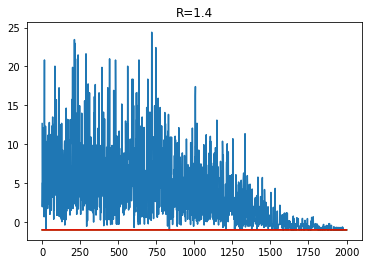

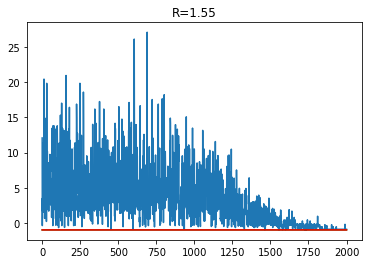

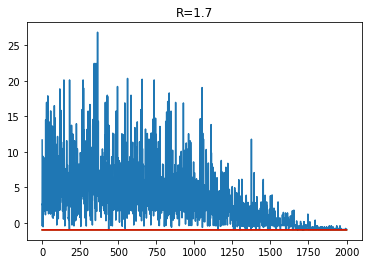

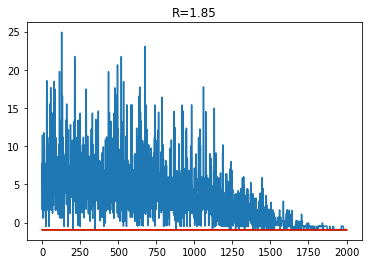

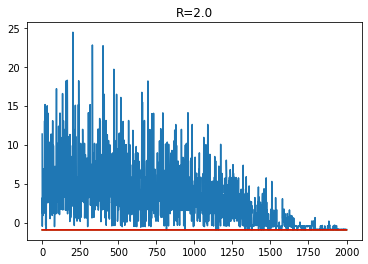

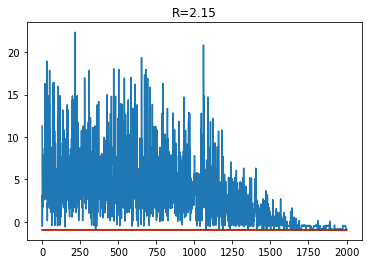

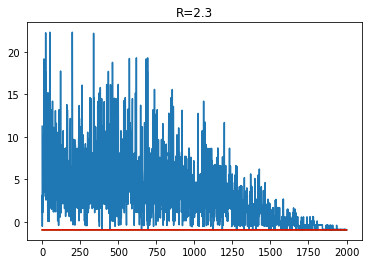

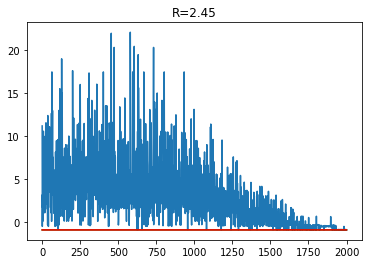

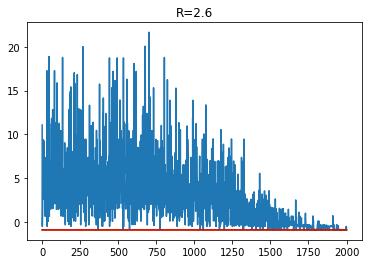

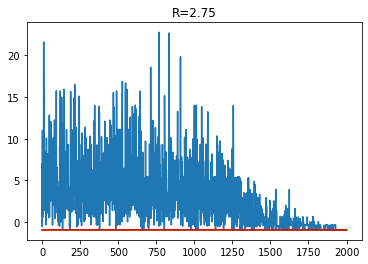

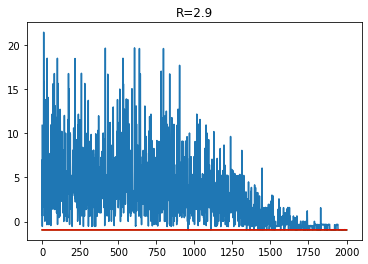

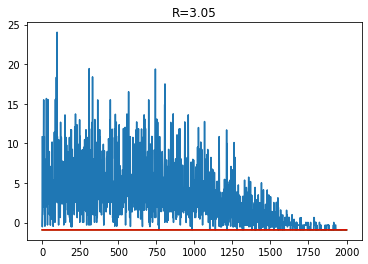

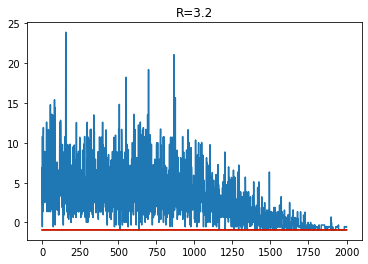

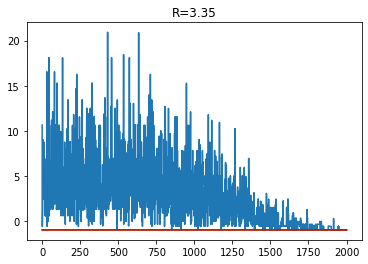

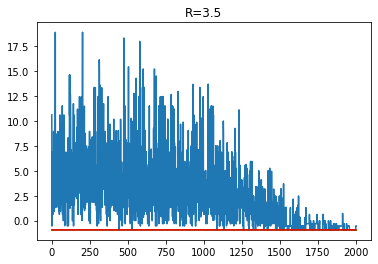

In [33]:
hamiltonians = [f for f in glob('hamiltonians/Ising-H2-STO-3G-bk-samespin-R=*.inp')]

df = pd.DataFrame(columns=["Ea", "Et"])
for hamiltonian_file in sorted(hamiltonians):
    match = re.match(r"hamiltonians/Ising-H2-STO-3G-bk-samespin-R=([\d.]+).inp", hamiltonian_file)
    r = float(match.groups(0)[0])
    E0, h, J, K, L = read_generalized_ising_hamiltonian(hamiltonian_file)
    expr = construct_hamiltonian_expr(E0, h, J, K, L)
    reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
    E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
    ising = IsingModel2D(E0, h, J)
    Ea, Et = calc_once(ising, exp_schedule(500, 0.1, 2000), plot_title=f"R={r}")
    df.loc[r] = pd.Series({"Ea": Ea, "Et": Et})
    print("Difference to exact:", (Et - Ea))
df = df.sort_index()

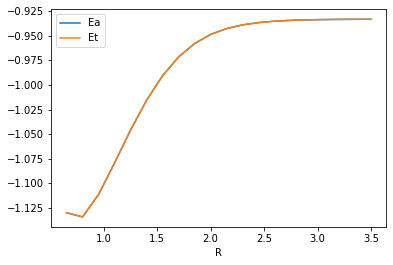

In [34]:
df.index.name = 'R'

df.plot()


